In [1]:
import numpy as np
from magnitude_function import *

/workspace/mnt/local/data/pgurevich/miniconda3/envs/magnitude/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
square = np.array([
    [0, 0],
    [0, 1],
    [1, 1],
    [1, 0], 
    [0.5, 0.5]
])

calculate_magnitude(square, eucledian_distance)

np.float64(2.0213717627666012)

In [39]:
t = np.linspace(0.0001, 10, 500)

mf = calculate_magnitude_function(square + 221, manhattan_distance, t)

100%|██████████| 500/500 [00:00<00:00, 11715.15it/s]


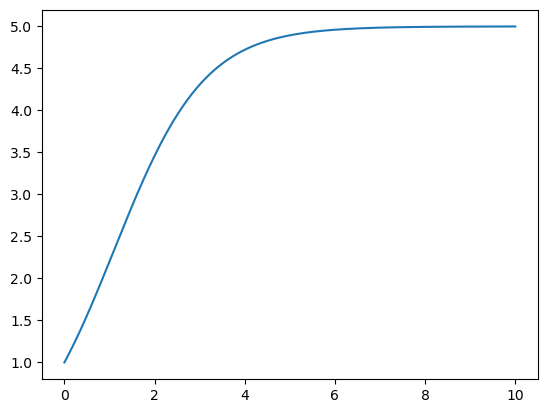

In [40]:
import matplotlib.pyplot as plt

plt.plot(t, mf)

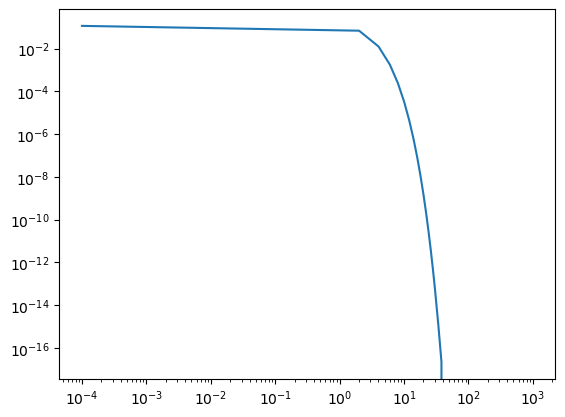

In [11]:
plt.loglog(t, calculate_dimension(mf, t))

In [29]:
# Create angle values from 0 to 2*pi
theta = np.linspace(0, 2*np.pi, 90)

# Radius of the circle
radius = 1

# Calculate x and y coordinates
x = radius * np.cos(theta).reshape(-1, 1)
y = radius * np.sin(theta).reshape(-1, 1) 

coords = np.concatenate([x, y], axis=1)
calculate_magnitude(coords, manhattan_distance)

np.float64(2.3533419046144335)

In [33]:
t = np.linspace(0.2, 50, 500)
mf = calculate_magnitude_function(coords, manhattan_distance, t)

100%|██████████| 500/500 [00:02<00:00, 195.56it/s]


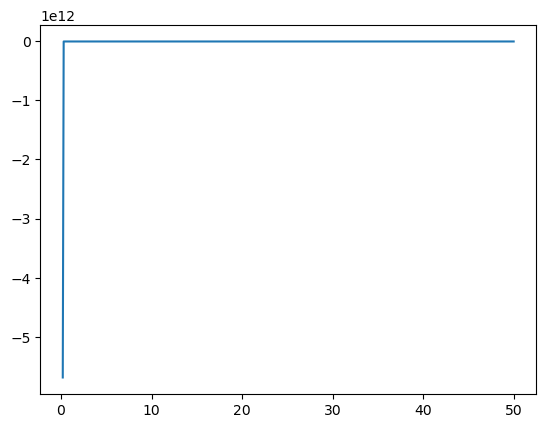

In [34]:
plt.plot(t, mf)

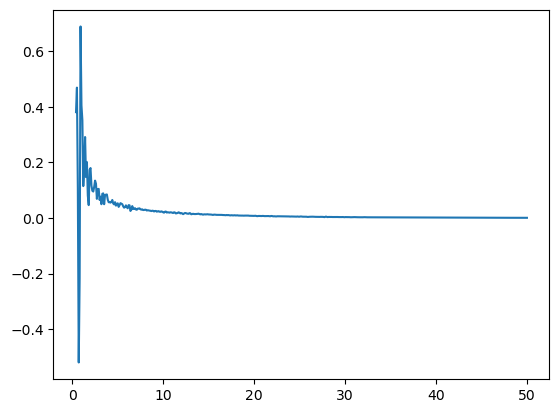

In [35]:
plt.plot(t, calculate_dimension(mf, t))

In [73]:
import torch

EMB_PATH = "/workspace/mnt/local/data/pgurevich/magnitude/embeddings.pt"
LAB_PATH = "/workspace/mnt/local/data/pgurevich/magnitude/labels.pt"

embs = torch.load(EMB_PATH)
labs = torch.load(LAB_PATH)

/tmp/ipykernel_944552/861918728.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(EMB_PATH)
/tmp/ipykernel_944552/861918728.py:7: FutureWarning: You are 

In [121]:
reals_inds = torch.where(labs == 0)[0]
generated_inds = torch.where(labs == 1)[0]

reals = embs[reals_inds]
gens = embs[generated_inds]


In [122]:
real_mags = [calculate_magnitude(x * 0.01, manhattan_distance) for x in tqdm(reals)]

100%|██████████| 500/500 [01:44<00:00,  4.78it/s]


In [123]:
gen_mags = [calculate_magnitude(x * 0.01, manhattan_distance) for x in tqdm(gens)]

100%|██████████| 500/500 [01:45<00:00,  4.74it/s]


(array([  6.,  17.,  76., 127., 135.,  75.,  44.,  13.,   3.,   4.]),
 array([24.18761063, 25.59622765, 27.00484467, 28.41345978, 29.8220768 ,
        31.23069382, 32.63931274, 34.04792786, 35.45654297, 36.8651619 ,
        38.27377701]),
 <BarContainer object of 10 artists>)

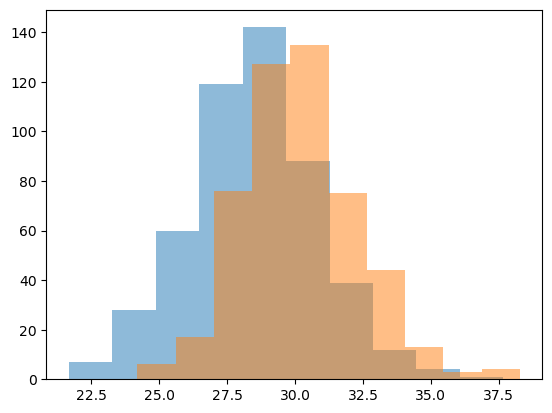

In [124]:
plt.hist(real_mags, alpha=0.5)
plt.hist(gen_mags, alpha=0.5)

In [125]:
t = np.linspace(0.0009, 0.02, 50)

real_mfs = [calculate_magnitude_function(x, manhattan_distance, t) for x in reals[:30]]
gen_mfs = [calculate_magnitude_function(x, manhattan_distance, t) for x in gens[:30]]

100%|██████████| 50/50 [00:10<00:00,  4.96it/s]


(1.0, 110.0)

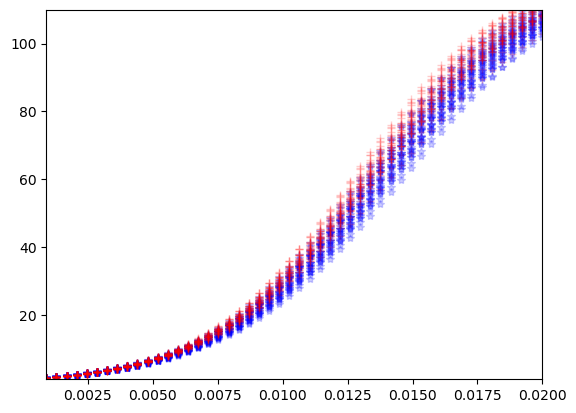

In [128]:
plt.plot(t, np.array(real_mfs).T, 'b*', alpha=0.2)
plt.plot(t, np.array(gen_mfs).T,  "r+", alpha=0.2)
plt.xlim(0.0009, 0.02)
plt.ylim(1, 110)